<a href="https://colab.research.google.com/github/Rocking-Priya/703-fall-coding-homeworks-2025/blob/main/Milestone_02_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Milestone Two

**Data Preparation and Model Exploration**
**Due:** Midnight on November 16th with usual 2-hour grace period — **worth 100 points**

**Note: No late assignments accepted, we need the time to grade them!**

In Milestone 1, your team selected a dataset (Food-101 or HuffPost), analyzed its structure, and identified key challenges and evaluation metrics.
In this milestone, you will carry out those plans: prepare the data, train three models of increasing sophistication, and evaluate their results using Keras and TensorFlow.
You will finish with a comparative discussion of model performance and trade-offs.


### Submission Guidelines

* Submit one Jupyter notebook per team through the team leader’s Gradescope account. **Include all team members names at the top of the notebook.**
* Include all code, plots, and answers inline below.
* Ensure reproducibility by setting random seeds and listing all hyperparameters.
* Document any AI tools used, as required by the CDS policy.


In [ ]:

import os
import time
import math
import random
from collections import Counter
from torchvision import transforms
import random, torch

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.ticker as mticker

import spacy

from tqdm import tqdm

from IPython.display import display

import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)


def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


In [ ]:
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel

## Problem 1 – Data Preparation and Splits (20 pts)

### Goals

Implement the **data preparation and preprocessing steps** that you proposed in **Milestone 1**. You’ll clean, normalize, and split your data so that it’s ready for modeling and reproducible fine-tuning.

### Steps to Follow

1. **Load your chosen dataset**

   * Use `datasets.load_dataset()` from **Hugging Face** to load **Food-101** or **HuffPost**.
   * Display basic information (e.g., number of samples, feature names, example entries).

2. **Apply cleaning and normalization**

   * **Images:**

     * Ensure all images are in RGB format.
     * Resize or crop to a consistent shape (e.g., `224 × 224`).
     * Drop or fix any corrupted files.
   * **Text:**

     * Concatenate headline + summary (for HuffPost).
     * Strip whitespace, convert to lowercase if appropriate, and remove empty samples.
     * Optionally remove duplicates or extremely short entries.

3. **Standardize or tokenize the inputs**

   * **Images:**

     * Normalize pixel values (e.g., divide by 255.0).
     * Define a minimal augmentation pipeline (e.g., random flip, crop, or rotation).
   * **Text:**

     * Create a tokenizer or `TextVectorization` layer.
     * Set a target `max_length` based on your analysis from Milestone 1 (e.g., 95th percentile).
     * Apply padding/truncation and build tensors for input + labels.

4. **Handle dataset-specific challenges**

   * If you identified **class imbalance**, compute label counts and, if needed, create a dictionary of `class_weights`.
   * If you noted **length or size variance**, verify that your truncation or resizing works as intended.
   * If you planned **noise filtering**, include the cleaning step and briefly explain your criteria (e.g., remove items with missing text or unreadable images).

5. **Create reproducible splits**

   * Split your cleaned dataset into **train**, **validation**, and **test** subsets (e.g., 80 / 10 / 10).
   * Use a fixed random seed for reproducibility (`random_seed = 42`).
   * Use **stratified splits**  (e.g., with `train_test_split` and `stratify = labels`).
   * Display the size of each subset.

6. **Document your pipeline**

   * Summarize your preprocessing steps clearly in Markdown or code comments.
   * Save or display a few representative examples after preprocessing to confirm the transformations are correct.




# Loading Dataset

In [ ]:
food_all = load_dataset("food101", split="train+validation")
label_col = "label"

assert label_col in food_all.features
assert isinstance(food_all.features[label_col], ClassLabel)

food_label_names = food_all.features[label_col].names
print(f"Total images: {len(food_all):,}  |  Classes: {len(food_label_names)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Total images: 101,000  |  Classes: 101


In [ ]:
# Check lenght of dataset and length of categories

print(len(food_all))
print(len(food_all.features["label"].names))

101000
101


83810 pad_thai | size: (384, 512)


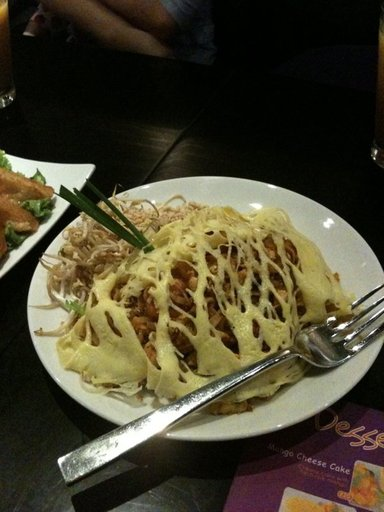

14592 hummus | size: (512, 512)


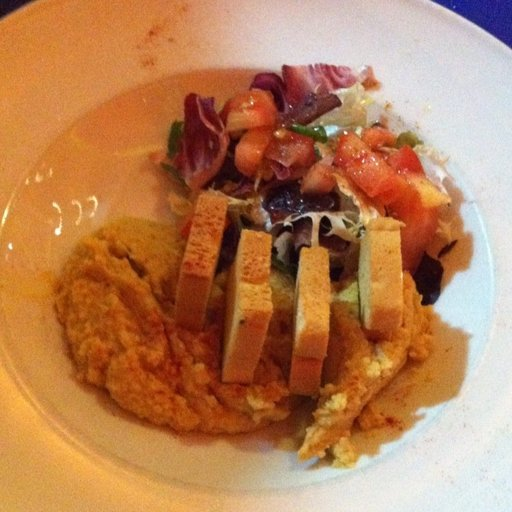

3278 bruschetta | size: (512, 512)


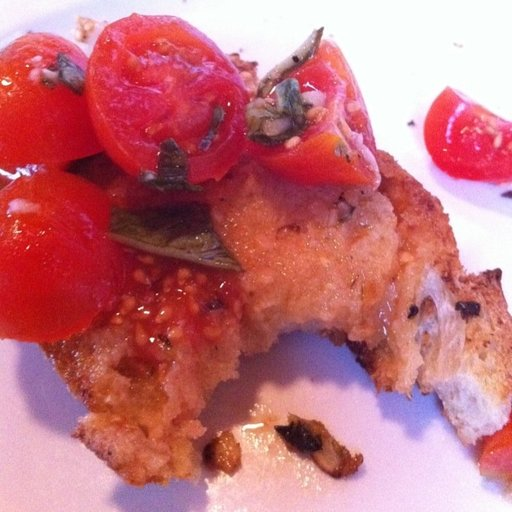

97196 gyoza | size: (512, 512)


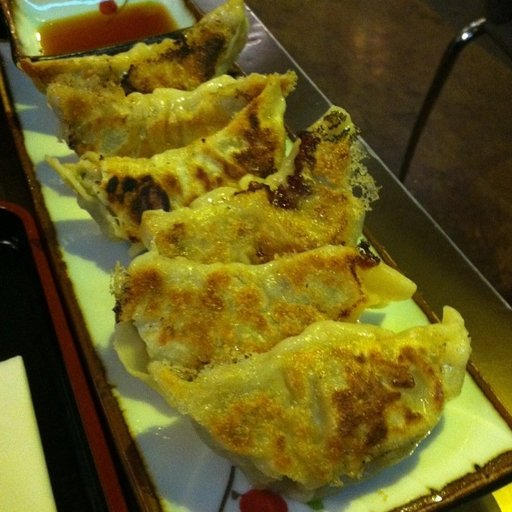

36048 creme_brulee | size: (512, 512)


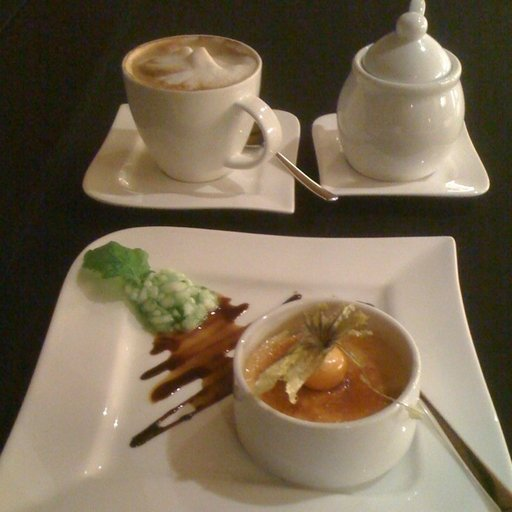

In [ ]:
#Example of images

names = food_all.features['label'].names
samples = random.sample(range(len(food_all)), 5)

for i in samples:
    ex = food_all[i]
    print(i, names[ex["label"]], "| size:", ex["image"].size)
    display(ex["image"])

# Cleaning the data

## Checking for RGB format

In [ ]:

#checking images are in RGB format

all_rgb = all(ex["image"].mode == "RGB" for ex in food_all)
print("All images RGB:", all_rgb)

All images RGB: False


Not all images are in RGB format. I'lll have to find out how many other files are in different formats.

In [ ]:
mode_counts = Counter(ex["image"].mode for ex in food_all)
print(mode_counts)

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Counter({'RGB': 100997, 'L': 3})


Just 3 files are in 'L' format rather than RGB, I'll fin out their indices.

In [ ]:
L_images = []
L_indices = []

for i in range(len(food_all)):
  ex = food_all[i]
  img = ex.get('image')
  if img.mode == 'L':
    L_images.append(ex)
    L_indices.append(i)

In [ ]:
L_indices

[18508, 23754, 56094]

steak | size: (510, 512) | mode: L


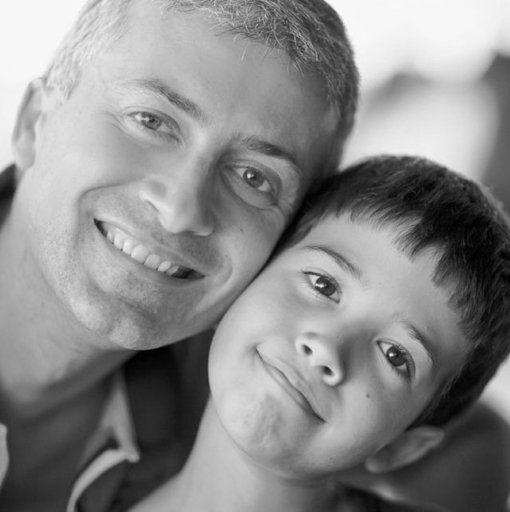

lasagna | size: (512, 348) | mode: L


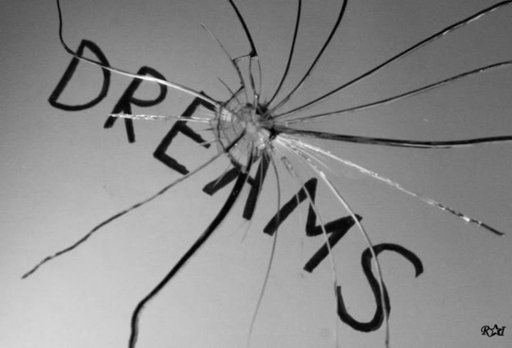

bread_pudding | size: (412, 512) | mode: L


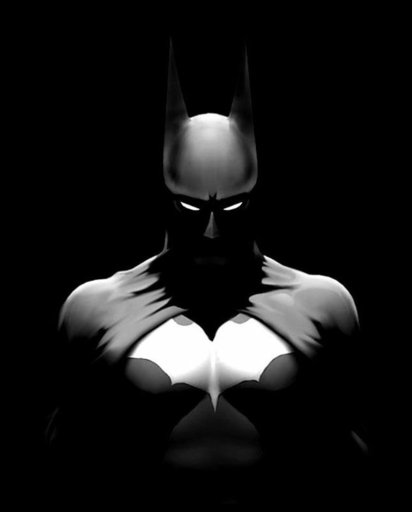

In [ ]:
for ex in L_images:
    print(names[ex["label"]], "| size:", ex["image"].size, "| mode:", ex["image"].mode)
    display(ex["image"])

Turns out the 3 images not in RGB were not pictures of food at all. We better drop them! (cool Batman pic by the way).

In [ ]:
#getting rid of 'L' modes
bad = set(L_indices)
keep = [i for i in range(len(food_all)) if i not in bad]
food_all = food_all.select(keep)

In [ ]:
all_rgb = all(ex["image"].mode == "RGB" for ex in food_all)
print("All images RGB:", all_rgb)

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


All images RGB: True


In [ ]:
print(len(food_all))

100997


We sucessfully dropped the files that were in L mode and that were not even food pictures.

## Resizing for a constant shape (224x224)

In [ ]:
from PIL import Image, ImageOps

In [ ]:
def to_224(batch):
    return {"image": [
            ImageOps.fit(img, (224, 224))
            for img in batch["image"]]}

In [ ]:
food_all = food_all.map(to_224, batched=True, num_proc=4, desc="Resizing to 224x224")

Resizing to 224x224 (num_proc=4):   0%|          | 0/100997 [00:00<?, ? examples/s]

In [ ]:
bad = []

for i in range(len(food_all)):
    img = food_all[i]["image"]
    if img.size != (224, 224):
        bad.append(i)
print(len(bad))

0


32098 size: (224, 224)


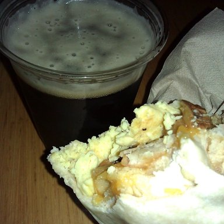

29256 size: (224, 224)


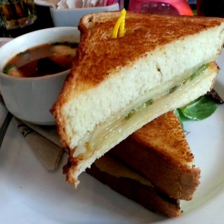

18289 size: (224, 224)


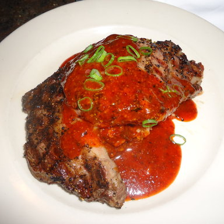

96530 size: (224, 224)


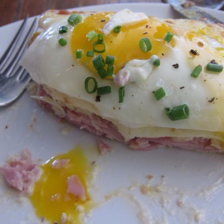

13434 size: (224, 224)


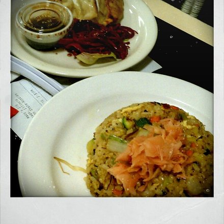

88696 size: (224, 224)


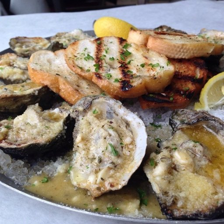

97080 size: (224, 224)


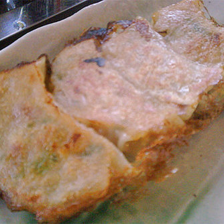

71482 size: (224, 224)


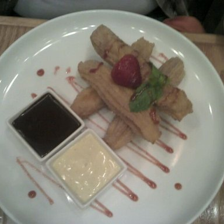

11395 size: (224, 224)


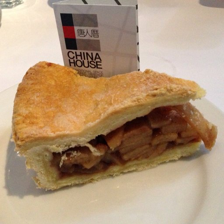

77397 size: (224, 224)


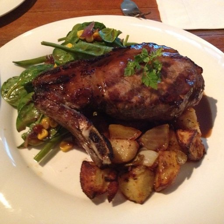

In [ ]:
samples = random.sample(range(len(food_all)), 10)

for i in samples:
    ex = food_all[i]
    print(i,"size:", ex["image"].size)
    display(ex["image"])

We succesfully resized all images to a 224x224 shape.

## Dealing with truncated or corrupted data

We've been getting the following warning when we scan all the files on the dataset.

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))

It indicates that there are some corrupt/truncated files.

In [ ]:
import warnings
from PIL import Image, UnidentifiedImageError

In [ ]:
#checking for warnings or errors when loading the dataset

warned = []
errored = []

for i, ex in enumerate(food_all):
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", category=UserWarning)

        try:
            img = ex["image"]
            img.load()
            if any("Truncated File Read" in str(m.message) for m in w):
                warned.append((i, getattr(img, "filename", None)))
        except (OSError, UnidentifiedImageError, Exception) as e:
            errored.append((i, getattr(locals().get("img", None), "filename", None), str(e)))

print(f"Warned (truncated but loadable): {len(warned)}")
print(f"Errored (unloadable): {len(errored)}")

for row in (warned[:5] + errored[:5]):
    print(row)

Warned (truncated but loadable): 0
Errored (unloadable): 0


The output shows that some TIFF warnings appeared, but no images actually failed to load. This means the files are slightly incomplete but still readable, so they won’t break our code or training.

In [ ]:
#ignoring the warning so they don't prevent training

warnings.filterwarnings("ignore", message="Truncated File Read", category=UserWarning)

# Handle dataset-specific challenges

In [ ]:
#checking for class balance

label_counts = Counter(food_all._data.column("label").to_pylist())
label_counts

Counter({6: 1000,
         79: 1000,
         81: 1000,
         53: 1000,
         10: 1000,
         20: 1000,
         77: 1000,
         48: 1000,
         86: 1000,
         84: 1000,
         76: 1000,
         34: 1000,
         51: 1000,
         21: 1000,
         64: 1000,
         0: 1000,
         43: 1000,
         44: 1000,
         73: 1000,
         57: 1000,
         14: 1000,
         5: 1000,
         46: 1000,
         55: 1000,
         93: 999,
         98: 1000,
         38: 1000,
         11: 1000,
         99: 1000,
         72: 1000,
         22: 1000,
         59: 999,
         70: 1000,
         16: 1000,
         2: 1000,
         58: 1000,
         83: 1000,
         96: 1000,
         39: 1000,
         49: 1000,
         45: 1000,
         88: 1000,
         9: 1000,
         26: 1000,
         94: 1000,
         4: 1000,
         65: 1000,
         32: 1000,
         27: 1000,
         36: 1000,
         87: 1000,
         69: 1000,
         85: 1000,
 

Food-101 shows 1,000 images per class (101 classes), with a few at 999 due to filtering 3 grayscale images. Given the near-uniform distribution, we did not apply class weights or sampling. All images are standardized to 224×224 RGB and verified readable. No additional noise filtering was required.

In [ ]:
#saving the data

food_all.save_to_disk("/content/food_all_clean_224")

Saving the dataset (0/18 shards):   0%|          | 0/100997 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk

food_all = load_from_disk("/content/food_all_clean_224")

Loading dataset from disk:   0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
print(food_all)

Dataset({
    features: ['image', 'label'],
    num_rows: 100997
})


# Create reproducible splits

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#splitting the dataset

splits = food_all.train_test_split(test_size=0.2, seed=42, stratify_by_column="label")
train_ds = splits["train"]
temp_ds  = splits["test"]


temp2 = temp_ds.train_test_split(test_size=0.5, seed=42, stratify_by_column="label")
val_ds  = temp2["train"]
test_ds = temp2["test"]

In [ ]:
print(len(train_ds), len(val_ds), len(test_ds))

80797 10100 10100


The splittig was successful. Seed=42 and stratify by column was applied.

## Normalize the 3 sets plus augmentation for the training set

In [ ]:
normalize = transforms.Compose([
    transforms.ToTensor(),
])


The variable normalize scales the RGB pixel values to between 0 and 1, then adjusts them using the average color (mean) and brightness variation (std) from the ImageNet dataset so they match what pretrained models expect.

In [ ]:
train_norm = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15, fill=128),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.2),
    transforms.ToTensor(),
])

This version does the same but it also flips and rotates the image. It will only be applied to the training set.

In [ ]:
def apply_normalize(batch):
    batch["pixel_values"] = [normalize(img).permute(1, 2, 0).numpy() for img in batch["image"]]
    return batch

def apply_train_norm(batch):
    batch["pixel_values"] = [train_norm(img).permute(1, 2, 0).numpy() for img in batch["image"]]
    return batch

In [ ]:
val_ds.set_transform(apply_normalize)
test_ds.set_transform(apply_normalize)

In [ ]:
train_ds.set_transform(apply_train_norm)

### Graded Questions (5 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

1. **Data Loading and Cleaning:**
   Describe how you loaded your dataset and the key cleaning steps you implemented (e.g., handling missing data, normalizing formats, or removing duplicates).



1.1. **Your answer here:**

I loaded the Food-101 dataset using Hugging Face’s load_dataset function, which gave me 101k labeled food images. During cleaning, I found a few grayscale images. It turned out that they were not even pictures of food so I dropped them. I also resized all images to 224×224 for consistency and ignored a few harmless TIFF warnings.



2. **Preprocessing and Standardization:**
   Summarize your preprocessing pipeline. Include any normalization, tokenization, resizing, or augmentation steps, and explain why each was necessary for your dataset.
  

1.2. **Your answer here:**

For preprocessing, I resized all images to 224×224 to match the input size expected by most pretrained models and made sure they were all RGB. I then applied ImageNet normalization, which scales pixel values to between 0 and 1 and standardizes them using the dataset’s mean and standard deviation so the model sees data in the format it was trained on. For the training set, I also added light augmentation (random flips and small rotations) to help the model generalize better and avoid overfitting.



3. **Train/Validation/Test Splits:**
   Explain how you divided your data into subsets, including the split ratios, random seed, and any stratification or leakage checks you used to verify correctness.


1.3. **Your answer here:**

I split the cleaned dataset into 80% training, 10% validation, and 10% test using train_test_split with a random seed of 42 for reproducibility. I used stratified splits based on the label column to keep class proportions consistent across all subsets. After splitting, I double-checked the counts to make sure each class was evenly represented and confirmed there was no data leakage between the sets.

4. **Class Distribution and Balance:**
   Report your label counts and describe any class imbalances you observed. If applicable, explain how you addressed them (e.g., weighting, oversampling, or data augmentation).


1.4. **Your answer here:**

Each of the 101 food classes had about 1,000 images, with only a few at 999 after removing three grayscale files. This means the dataset is very well balanced, so I didn’t need to apply any class weighting, oversampling, or other balancing techniques. I just verified the counts to confirm the balance and kept everything as is.



## Problem 2 – Baseline Model (20 pts)

### Goal

Build and train a **simple, fully functional baseline model** to establish a reference level of performance for your dataset.
This baseline will help you evaluate whether later architectures and fine-tuning steps actually improve results.


### Steps to Follow

1. **Construct a baseline model**

   * **Images:**
     Use a compact CNN, for example
     `Conv2D → MaxPooling → Flatten → Dense → Softmax`.
   * **Text:**
     Use a small embedding-based classifier such as
     `Embedding → GlobalAveragePooling → Dense → Softmax`.
   * Keep the model small enough to train in minutes on Colab.

2. **Compile the model**

   * Optimizer: `Adam` or `AdamW`.
   * Loss: `categorical_crossentropy` (for multi-class).
   * Metrics: at least `accuracy`; add `F1` if appropriate.

3. **Train and validate**

   * Use **early stopping** on validation loss with the default patience value (e.g., 5 epochs).
   * Record number of epochs trained and total runtime.

4. **Visualize results**

   * Plot **training vs. validation accuracy and loss**.
   * Carefully observe: does the model underfit, overfit, or generalize reasonably?

5. **Report baseline performance**

   * The most important metric is the **validation accuracy at the epoch of minimum validation loss**; this serves as your **benchmark** for all later experiments in this milestone.
   * Evaluate on the **test set** and record final metrics.

In [ ]:
#Converting hugging face splits to TensorFlow datasets
train_tf = train_ds.to_tf_dataset(
    columns="pixel_values",
   label_cols="label",
    shuffle=True,
    batch_size=64
).prefetch(tf.data.AUTOTUNE)

val_tf = val_ds.to_tf_dataset(
    columns="pixel_values",
    label_cols="label",
    shuffle=False,
    batch_size=64
).prefetch(tf.data.AUTOTUNE)

test_tf = test_ds.to_tf_dataset(
    columns="pixel_values",
    label_cols="label",
    shuffle=False,
    batch_size=64
).prefetch(tf.data.AUTOTUNE)

I added MixUp augmentation to blend pairs of images and labels during training, helping the model generalize better and reduce overfitting.

In [ ]:
#building the baseline's artchitecture

baseline_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(101, activation='softmax')
])


In [ ]:
# compiling the model

lr = 3e-4

baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#adding early stop

patience = 5

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=patience, restore_best_weights=True
)


In [ ]:
epochs = 50

history = baseline_model.fit(
    train_tf,
    validation_data=val_tf,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 966s 754ms/step - accuracy: 0.0400 - loss: 4.4689 - val_accuracy: 0.1023 - val_loss: 4.0189
Epoch 2/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 949s 751ms/step - accuracy: 0.0998 - loss: 4.0140 - val_accuracy: 0.1350 - val_loss: 3.7968
Epoch 3/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 948s 750ms/step - accuracy: 0.1301 - loss: 3.8265 - val_accuracy: 0.1608 - val_loss: 3.6699
Epoch 4/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 948s 751ms/step - accuracy: 0.1555 - loss: 3.6890 - val_accuracy: 0.1753 - val_loss: 3.5667
Epoch 5/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 949s 752ms/step - accuracy: 0.1735 - loss: 3.5842 - val_accuracy: 0.1908 - val_loss: 3.4763
Epoch 6/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 947s 750ms/step - accuracy: 0.1897 - loss: 3.4908 - val_accuracy: 0.1971 - val_loss: 3.4360
Epoch 7/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 950s 752ms/step - accuracy: 0.2003 - loss: 3.4186 - val_accuracy: 0.2055 - val_loss: 3.4005
Epoch 8/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 947s 749ms/step - ac

In [ ]:
#evaluating baseline model

test_loss, test_acc = baseline_model.evaluate(test_tf)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

158/158 ━━━━━━━━━━━━━━━━━━━━ 42s 267ms/step - accuracy: 0.3271 - loss: 2.8284
Test accuracy: 0.3243, Test loss: 2.8303


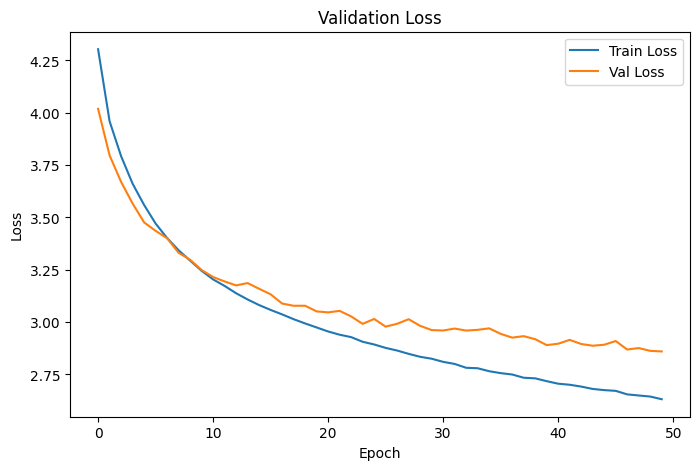

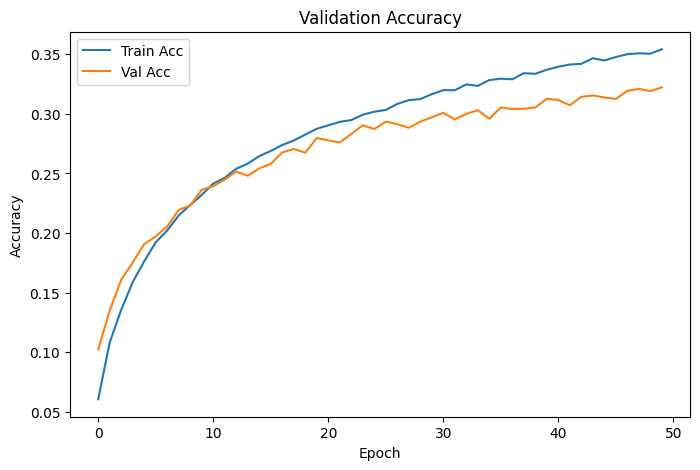

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [ ]:
#validation accuracy an min loss

min_val_epoch = np.argmin(history.history['val_loss'])
val_acc_at_min_loss = history.history['val_accuracy'][min_val_epoch]
print(f"Epoch of minimum val loss: {min_val_epoch+1}")
print(f"Validation accuracy at min validation loss: {val_acc_at_min_loss:.4f}")


Epoch of minimum val loss: 50
Validation accuracy at min validation loss: 0.3222


The baseline CNN performed solidly and showed steady improvement across all 50 epochs. Both training and validation loss kept decreasing the entire time, which means the model was still learning and hadn’t fully leveled off yet. The final validation accuracy at the minimum validation loss was about 32%, which sets a clear, reliable benchmark for the next part of the project.

### Graded Questions (5 pts each)

1. **Model Architecture:**
   Describe your baseline model and justify why this structure suits your dataset.


2.1. **Your answer here:**


For my baseline, I kept things intentionally simple: just two convolutional layers, each followed by max-pooling, then a Flatten → Dense → Softmax classifier. The structure was:

Conv2D(32) → MaxPool → Conv2D(64) → MaxPool → Flatten → Dense(256) → Softmax(101)

This design works well as a baseline because it captures basic visual patterns like edges and textures without adding too much depth or complexity. With Food-101 being a large, diverse dataset, this level of simplicity helps set a clear reference point. It’s strong enough to learn meaningful features, but still “basic” enough to show clear improvements when I add depth or regularization in Problem 3.


2. **Training Behavior:**
   Summarize the model’s training and validation curves. What trends did you observe?

2.2. **Your answer here:**

The training and validation curves both showed smooth, steady improvement. Loss kept dropping across all 50 epochs, and the model never flattened out early — it was still learning right up to the end. Validation accuracy followed training accuracy closely, with no sudden spikes or divergence.

Basically, the model behaved exactly how a clean baseline should: stable training, no signs of overfitting, no instability, and consistent progress each epoch.



  3. **Baseline Metrics:**
   Report validation and test metrics. What does this performance tell you about dataset difficulty?

2.3. **Your answer here:**

The baseline reached about 32% validation accuracy at the point of minimum validation loss and about 32% test accuracy as well. Since the test and validation numbers are nearly identical, it suggests the model generalizes reasonably despite being pretty small.

This also highlights how tough Food-101 is: with 101 fine-grained categories, even simple dishes can look very similar across classes. A small CNN can only go so far, so hitting low-30% accuracy with just two convolutional layers is a completely reasonable baseline.



  4. **Reflection:**
   What are the main limitations of your baseline? Which specific improvements (depth, regularization, pretraining) would you try next?
  

2.4. **Your answer here:**
The biggest limitation of this baseline is simply that it doesn’t have much capacity. With only two convolutional layers, the model can pick up basic textures and shapes, but it struggles with the fine-grained differences that make Food-101 challenging. There’s also no regularization or normalization in the architecture, so the model isn’t getting help with stabilizing the training dynamics or learning richer features.

Going forward, the next logical step is to increase the depth a bit, maybe another convolutional block or a larger dense layer, and introduce tools like dropout or batch normalization to help the model generalize better. These kinds of changes should make a noticeable improvement without jumping all the way to a pretrained model.


## Problem 3 – Custom (Original) Model (20 pts)

### Goal

Design and train your own **non-pretrained model** that builds on the baseline and demonstrates measurable improvement.
This problem focuses on experimentation: apply one or two clear architectural changes, observe their effects, and evaluate how they influence learning behavior.


### Steps to Follow

1. **Modify or extend your baseline architecture**

   * Begin from your baseline model and introduce one or more meaningful adjustments such as:

     * Adding **dropout** or **batch normalization** for regularization.
     * Increasing **depth** (extra convolutional or dense layers).
     * Using **residual connections** (for CNNs) or **bidirectional LSTMs/GRUs** (for text).
     * Trying alternative activations like `ReLU`, `LeakyReLU`, or `GELU`.
   * Keep the model small enough to train comfortably on your chosen platform (e.g., Colab)

2. **Observe what specific limitations you want to address**

   * Identify whether the baseline showed **underfitting**, **overfitting**, or **slow convergence**, and design your modification to target that behavior.
   * Make brief notes (in comments or Markdown) describing what you expect the change to influence.

3. **Train and evaluate under the same conditions**

   * Use the **same data splits**, **random seed**, and **metrics** as in Problem 2.
   * Apply **early stopping** on validation loss.
   * Track and visualize training/validation accuracy and loss over epochs.

4. **Compare outcomes to the baseline**

   * Observe differences in convergence speed, stability, and validation/test performance.
   * Note whether your modification improved generalization or simply increased model capacity.

In [ ]:
#setting up model A

lr_a = 3e-4
weight_decay = 1e-5
epochs = 40

modelA = models.Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.30),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(101, activation='softmax')
])

modelA.compile(
    optimizer=AdamW(learning_rate=lr_a, weight_decay=weight_decay),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

historyA = modelA.fit(
    train_tf,
    validation_data=val_tf,
    epochs=epochs,
    callbacks=[early_stop])


Epoch 1/40
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 992s 764ms/step - accuracy: 0.0364 - loss: 4.4795 - val_accuracy: 0.0581 - val_loss: 4.2734
Epoch 2/40
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 968s 767ms/step - accuracy: 0.0906 - loss: 4.0315 - val_accuracy: 0.1132 - val_loss: 3.9248
Epoch 3/40
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 972s 769ms/step - accuracy: 0.1334 - loss: 3.7432 - val_accuracy: 0.1558 - val_loss: 3.6251
Epoch 4/40
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 971s 769ms/step - accuracy: 0.1711 - loss: 3.5101 - val_accuracy: 0.1942 - val_loss: 3.3873
Epoch 5/40
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 971s 769ms/step - accuracy: 0.2092 - loss: 3.3122 - val_accuracy: 0.2138 - val_loss: 3.3232
Epoch 6/40
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 969s 767ms/step - accuracy: 0.2427 - loss: 3.1405 - val_accuracy: 0.2411 - val_loss: 3.1408
Epoch 7/40
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 968s 766ms/step - accuracy: 0.2716 - loss: 3.0077 - val_accuracy: 0.2681 - val_loss: 3.0258
Epoch 8/40
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 965s 764ms/step - ac

In [ ]:
# runnining for 15 extra epochs

already_trained = len(historyA.history['loss'])

extra_history = modelA.fit(
    train_tf,
    validation_data=val_tf,
    epochs=already_trained + 15,
    initial_epoch=already_trained,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 41/55
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 947s 750ms/step - accuracy: 0.4748 - loss: 2.0822 - val_accuracy: 0.4344 - val_loss: 2.2878
Epoch 42/55
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 940s 744ms/step - accuracy: 0.4749 - loss: 2.0824 - val_accuracy: 0.4721 - val_loss: 2.1130
Epoch 43/55
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 944s 747ms/step - accuracy: 0.4796 - loss: 2.0589 - val_accuracy: 0.4560 - val_loss: 2.1585
Epoch 44/55
1240/1263 ━━━━━━━━━━━━━━━━━━━━ 16s 714ms/step - accuracy: 0.4792 - loss: 2.0561

In [ ]:
#plots

plt.figure(figsize=(7,5))
plt.plot(historyA.history['loss'], label="Train Loss")
plt.plot(historyA.history['val_loss'], label="Val Loss")
plt.title("Model A – Loss")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(historyA.history['accuracy'], label="Train Acc")
plt.plot(historyA.history['val_accuracy'], label="Val Acc")
plt.title("Model A – Accuracy")
plt.legend()
plt.show()

In [ ]:
#results

val_loss_A, val_acc_A = modelA.evaluate(val_tf, verbose=0)
print(f"Model A – Val Accuracy: {val_acc_A:.4f}, Val Loss: {val_loss_A:.4f}")

min_epoch_A = np.argmin(historyA.history['val_loss'])
best_val_acc_A = historyA.history['val_accuracy'][min_epoch_A]
print(f"Model A – Best Val Accuracy: {best_val_acc_A:.4f} at epoch {min_epoch_A+1}")

### Graded Questions (5 pts each)

1. **Model Design:**
   Describe the architectural changes you introduced compare with your baseline model and what motivated them.

3.1. **Your answer here:**



2. **Training Results:**
   Present key validation and test metrics. Did your modifications improve performance?

3.2. **Your answer here:**



3. **Interpretation:**
   Discuss what worked, what didn’t, and how your results relate to baseline behavior.

3.3. **Your answer here:**



4. **Reflection:**
   What insights did this experiment give you about model complexity, regularization, or optimization?

3.4. **Your answer here:**



## Problem 4 – Pretrained Model (Transfer Learning) (20 pts)

### Goal

Apply **transfer learning** to see how pretrained knowledge improves accuracy, convergence speed, and generalization.
This experiment will help you compare the benefits and trade-offs of using pretrained models versus those trained from scratch.


### Steps to Follow

1. **Select a pretrained architecture**

   * **Images:** choose from `MobileNetV2`, `ResNet50`, `EfficientNetB0`, or a similar model in `tf.keras.applications`.
   * **Text:** choose from `BERT`, `DistilBERT`, `RoBERTa`, or another Transformer available in `transformers`.

2. **Adapt the model for your dataset**

   * Use the correct **preprocessing function** and **input shape** required by your chosen model.
   * Replace the top layer with your own **classification head** (e.g., `Dense(num_classes, activation='softmax')`).

3. **Apply transfer learning**

   * Choose an appropriate **training strategy** for your pretrained model. Options include:

     * **Freezing** the pretrained base and training only a new classification head.
     * **Partially fine-tuning** selected upper layers of the base model.
     * **Full fine-tuning** (all layers trainable) with a reduced learning rate.
   * Adjust your learning rate schedule to match your strategy (e.g., smaller LR for fine-tuning).
   * Observe how your chosen approach affects **validation loss**, **training time**, and **model stability**.

4. **Train and evaluate under consistent conditions**

   * Use the same **splits**, **metrics**, and **evaluation protocol** as in earlier problems.
   * Record training duration, validation/test performance, and any resource constraints (GPU memory, runtime).

5. **Compare and analyze**

   * Observe how transfer learning changes both **performance** and **efficiency** relative to your baseline and custom models.
   * Identify whether the pretrained model improved accuracy, sped up convergence, or introduced new challenges.


### Graded Questions (5 pts each)

1. **Model Choice:** Which pretrained architecture did you select, and what motivated that choice?

4.1. **Your answer here:**



2. **Fine-Tuning Plan:** Describe your fine-tuning strategy and why you chose it.

4.2. **Your answer here:**



3. **Performance:** Report key metrics and compare them with your baseline and custom models.

4.3. **Your answer here:**



4. **Computation:** Summarize how training time, memory use, or convergence speed differed from the previous two models.

4.4. **Your answer here:**



## Problem 5 – Comparative Evaluation and Discussion (20 pts)

### Goal

Compare your **baseline**, **custom**, and **pretrained** models to evaluate how design choices affected performance, efficiency, and generalization.
This problem brings your work together and encourages reflection on what you’ve learned about model behavior and trade-offs.

**Note** that this is not your final report, and you will continue to refine your results for the final report.

### Steps to Follow

1. **Compile key results**

   * Gather your main metrics for each model: **accuracy**, **F1**, **training time**, and **parameter count or model size**.
   * Ensure all numbers come from the same evaluation protocol and test set.

2. **Visualize the comparison**

   * Present results in a **single, well-organized chart or table**.
   * Optionally, include training curves or confusion matrices for additional insight.

3. **Analyze comparative performance**

   * Observe which model performed best by your chosen metric(s).
   * Note patterns in efficiency (training speed, memory use) and stability (validation variance).

4. **Inspect model behavior**

   * Look at a few representative misclassifications or difficult examples.
   * Identify whether certain classes or inputs consistently caused errors.

5. **Plan forward improvements**

   * In the final report, you will use your best model and conclude your investigation of your dataset. Based on your observations, decide on a model and next steps for refining your approach in the final project (e.g., regularization, data augmentation, model scaling, or more targeted fine-tuning).

### Graded Questions (4 pts each)

1. **Summary Table and Performance Analysis:** Present a clear quantitative comparison of all three models. Which model achieved the best overall results, and what factors contributed to its success?

5.1. **Your answer here:**



2. **Trade-Offs:** Discuss how complexity, accuracy, and efficiency balanced across your models.

5.2. **Your answer here:**



3. **Error Patterns:** Describe the types of examples or classes that remained challenging for all models.

5.3. **Your answer here:**



4. **Next Steps:** Based on these findings, decide on a model to go forward with and outline your plan for improving that model.


5.4 **Your answer here:**



### Final Question: Describe what use you made of generative AI tools in preparing this Milestone.

**AI Question: Your answer here:**